In [1]:
#For such Files handling
import csv
with open("exchange_rate.csv", 'w',newline="") as file:
    csv_write = csv.writer(file, delimiter=',') #header
    csv_write.writerow(["Currency","Rate"]) #data /record
    csv_write.writerow(["EUR","0.93"])
    csv_write.writerow(["GBP","0.8"])
    csv_write.writerow(["INR","82.95"])

In [2]:
#Task 1: Logging Function
import logging

# Configure logging
logging.basicConfig(
    filename='entry.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

def log_message(message):
    logging.info(message)

# Example usage
log_message("This is a test log message.")


In [14]:
#Task 2,3: Extraction and Transformation Of Data
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import logging
import os.path

def log_message(message):
    logging.info(message)

def log_error(error):
    logging.error(error)

# Function to extract data from URL
def extract_data(url):
    log_message(f"Getting data from {url}...")
    response = requests.get(url)
    
    if response.status_code == 200:
        log_message('Successfully scraped.')
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    else:
        log_message('Failed to retrieve HTML content.')
        return None

# Function to transform data from BeautifulSoup to DataFrame
def transform_data(soup):
    tables = soup.find_all('table', class_='wikitable')
    if tables:
        table_str = str(tables[0])
        table_io = StringIO(table_str)
        df_list = pd.read_html(table_io)
        df = df_list[0]  # Assuming the first table is the one we need
        return df
    else:
        log_message("No tables found in the HTML content.")
        return None

# Function to apply exchange rates to DataFrame
def apply_exchange_rates(df, exchange_rates_csv):
    if not os.path.isfile(exchange_rates_csv):
        log_message(f"Exchange rates CSV '{exchange_rates_csv}' not found.")
        return None
    
    exchange_rates = pd.read_csv(exchange_rates_csv, index_col=0).to_dict()['Rate']

    df['MC_GBP_Billion'] = round(df['Market cap (US$ billion)'] * exchange_rates.get('GBP', 1.0), 2)
    df['MC_EUR_Billion'] = round(df['Market cap (US$ billion)'] * exchange_rates.get('EUR', 1.0), 2)
    df['MC_INR_Billion'] = round(df['Market cap (US$ billion)'] * exchange_rates.get('INR', 1.0), 2)
    
    return df

# Main execution
if __name__ == "__main__":
    # Define your URL and exchange rate CSV file path
    url = 'https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks'
    exchange_rate_csv = 'exchange_rate.csv'

    # Step 1: Extract data
    soup = extract_data(url)

    # Step 2: Transform data
    transformed_data = transform_data(soup)

    if transformed_data is not None:
        print("Before Applying Exchange Rates:")
        print(transformed_data.to_string(index=False))
        
        # Step 3: Apply exchange rates
        transformed_data_with_rates = apply_exchange_rates(transformed_data, exchange_rate_csv)

        if transformed_data_with_rates is not None:
            print("\nAfter Applying Exchange Rates:")
            print(transformed_data_with_rates.to_string(index=False))
        else:
            log_message("Failed to apply exchange rates.")
    else:
        log_message("Failed to transform data into DataFrame.")


Before Applying Exchange Rates:
 Rank                               Bank name  Market cap (US$ billion)
    1                          JPMorgan Chase                    432.92
    2                         Bank of America                    231.52
    3 Industrial and Commercial Bank of China                    194.56
    4              Agricultural Bank of China                    160.68
    5                               HDFC Bank                    157.91
    6                             Wells Fargo                    155.87
    7                       HSBC Holdings PLC                    148.90
    8                          Morgan Stanley                    140.83
    9                 China Construction Bank                    139.82
   10                           Bank of China                    136.81

After Applying Exchange Rates:
 Rank                               Bank name  Market cap (US$ billion)  MC_GBP_Billion  MC_EUR_Billion  MC_INR_Billion
    1                   

In [16]:
#Task 4: Loading to CSV

def load_to_csv(df, filename='transformed_data.csv'):
    df.to_csv(filename, index=False)
    log_message(f"Data loaded to CSV file: {filename}")

load_to_csv(transformed_data)

In [17]:
#Task 5: Loading to SQLite Database
import sqlite3
import pandas as pd

# Load the transformed data from CSV
transformed_data_csv = 'transformed_data.csv'
df_transformed = pd.read_csv(transformed_data_csv)

# Connect to SQLite database
conn = sqlite3.connect('banks_data.db')
df_transformed.to_sql('transformed_data', conn, if_exists='replace', index=False)
conn.close()


In [23]:
#Task 6: Function to Run queries on Database
import sqlite3
import logging

# Function to log informational messages
def log_message(message):
    logging.info(message)

# Function to log error messages
def log_error(error):
    logging.error(error)

def run_queries(db_name):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    queries = [
        "SELECT `Bank name` FROM transformed_data WHERE Rank > 5;",
        "SELECT `Bank name`, COUNT(*) as BankCount FROM transformed_data;",  
        "SELECT `Bank name`, SUM(`Market cap (US$ billion)`) as TotalMarketCap FROM transformed_data GROUP BY Rank ORDER BY TotalMarketCap;",
        "SELECT `Bank name`, `MC_INR_Billion` FROM transformed_data ORDER BY `MC_INR_Billion` LIMIT 5;"
    ]

    results = {}
    try:
        for i, query in enumerate(queries):
            log_message(f"Executing Query_{i+1}: {query}")
            cursor.execute(query)
            results[f'Query_{i+1}'] = cursor.fetchall()

        log_message("Queries executed successfully.")
    except Exception as e:
        log_error(f"Error executing queries: {e}")
    finally:
        conn.close()

    return results

# Run the queries and print the results
query_results = run_queries('banks_data.db')

for query, result in query_results.items():
    print(f"{query} Results:")
    for row in result:
        print(row)
    print()


Query_1 Results:
('Wells Fargo',)
('HSBC Holdings PLC',)
('Morgan Stanley',)
('China Construction Bank',)
('Bank of China',)

Query_2 Results:
('JPMorgan Chase', 10)

Query_3 Results:
('Bank of China', 136.81)
('China Construction Bank', 139.82)
('Morgan Stanley', 140.83)
('HSBC Holdings PLC', 148.9)
('Wells Fargo', 155.87)
('HDFC Bank', 157.91)
('Agricultural Bank of China', 160.68)
('Industrial and Commercial Bank of China', 194.56)
('Bank of America', 231.52)
('JPMorgan Chase', 432.92)

Query_4 Results:
('Bank of China', 11348.39)
('China Construction Bank', 11598.07)
('Morgan Stanley', 11681.85)
('HSBC Holdings PLC', 12351.26)
('Wells Fargo', 12929.42)



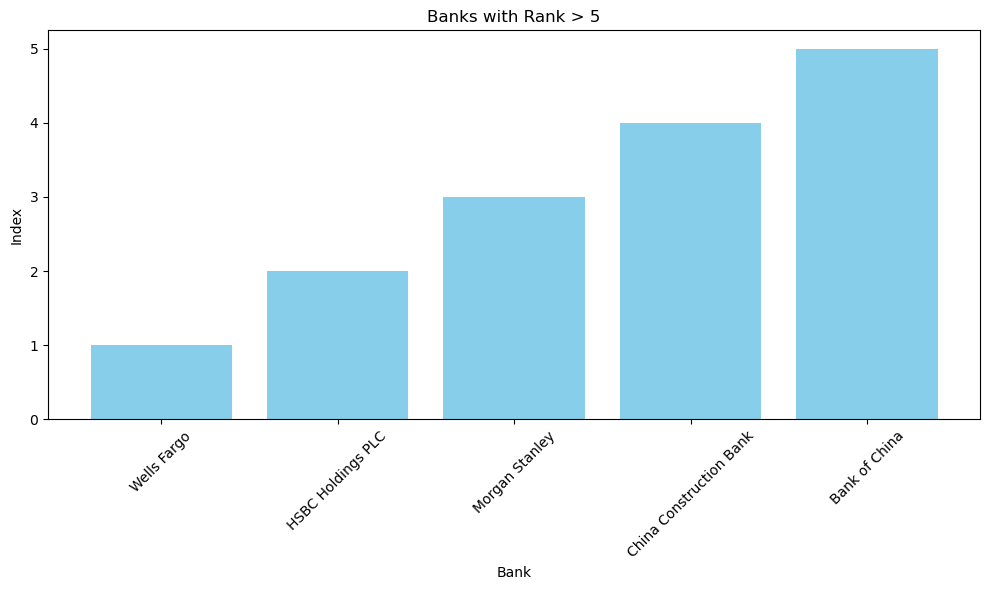

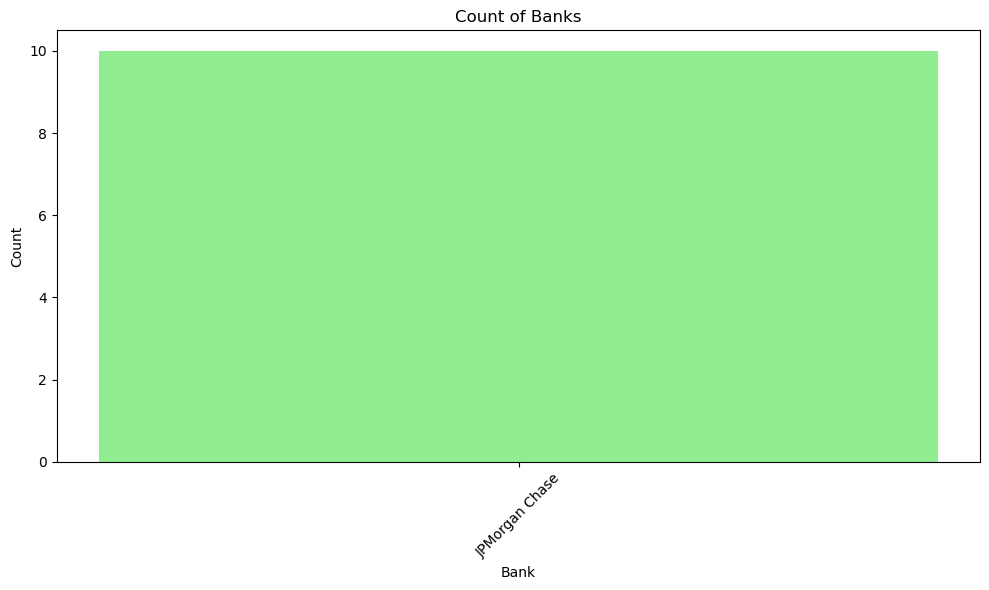

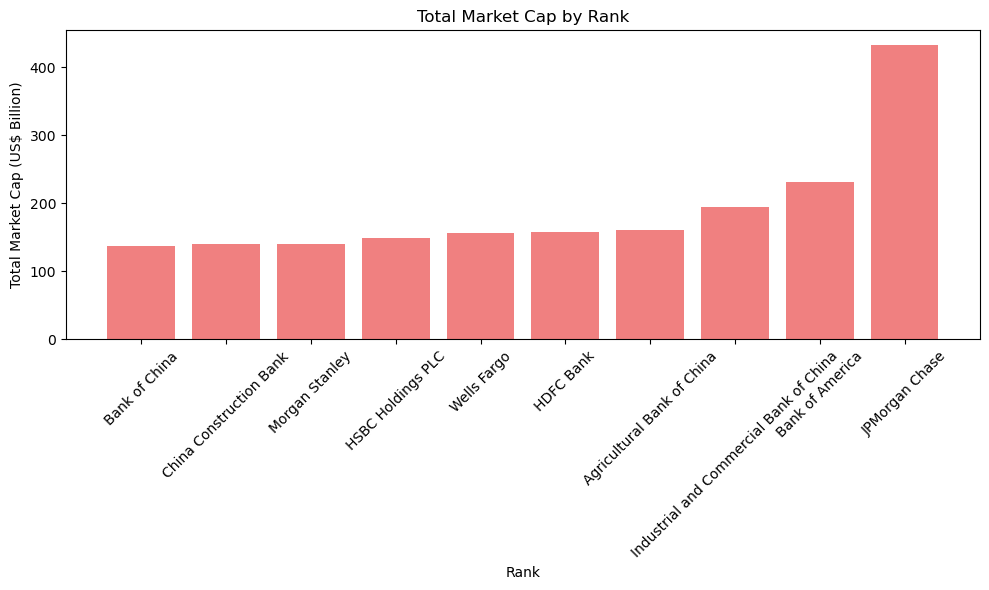

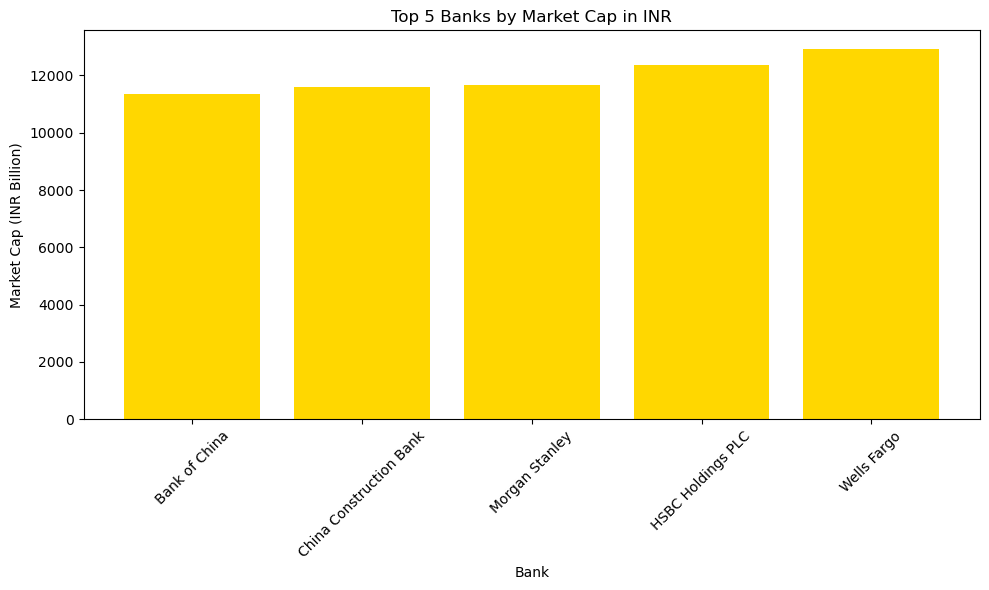

In [27]:
#Visualization
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Function to log informational messages
def log_message(message):
    logging.info(message)

# Example usage of log_message
# log_message("Starting visualization process.")

def plot_data(results):
    try:
        # Plotting Query 1: Banks with Rank > 5
        df_query_1 = pd.DataFrame(results['Query_1'], columns=['BankName'])
        plt.figure(figsize=(10, 6))
        plt.bar(df_query_1['BankName'], df_query_1.index + 1, color='skyblue')
        plt.xlabel('Bank')
        plt.ylabel('Index')
        plt.title('Banks with Rank > 5')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        log_message("Plotting Query 1: Banks with Rank > 5")

        # Plotting Query 2: Count of Banks
        df_query_2 = pd.DataFrame(results['Query_2'], columns=['BankName', 'BankCount'])
        plt.figure(figsize=(10, 6))
        plt.bar(df_query_2['BankName'], df_query_2['BankCount'], color='lightgreen')
        plt.xlabel('Bank')
        plt.ylabel('Count')
        plt.title('Count of Banks')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        log_message("Plotting Query 2: Count of Banks")

        # Plotting Query 3: Total Market Cap by Rank
        df_query_3 = pd.DataFrame(results['Query_3'], columns=['Rank', 'TotalMarketCap'])
        plt.figure(figsize=(10, 6))
        plt.bar(df_query_3['Rank'], df_query_3['TotalMarketCap'], color='lightcoral')
        plt.xlabel('Rank')
        plt.ylabel('Total Market Cap (US$ Billion)')
        plt.title('Total Market Cap by Rank')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        log_message("Plotting Query 3: Total Market Cap by Rank")

        # Plotting Query 4: Top 5 Banks by Market Cap in INR
        df_query_4 = pd.DataFrame(results['Query_4'], columns=['BankName', 'MarketCapINR'])
        plt.figure(figsize=(10, 6))
        plt.bar(df_query_4['BankName'], df_query_4['MarketCapINR'], color='gold')
        plt.xlabel('Bank')
        plt.ylabel('Market Cap (INR Billion)')
        plt.title('Top 5 Banks by Market Cap in INR')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        log_message("Plotting Query 4: Top 5 Banks by Market Cap in INR")

        log_message("All visualizations completed successfully.")
    except Exception as e:
        log_message(f"Error during plotting: {e}")

# Example usage
plot_data(query_results)


In [28]:
 #Task 7: Verify log entries
def verify_log():
    with open('entry.log', 'r') as log_file:
        print(log_file.read())

 verify_log()

2024-07-13 02:59:31,380:INFO:This is a test log message.
2024-07-13 03:00:25,929:INFO:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-07-13 03:00:25,929:INFO:NumExpr defaulting to 8 threads.
2024-07-13 03:00:26,246:INFO:Getting data from https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks...
2024-07-13 03:00:28,453:INFO:Successfully scraped.
2024-07-13 03:05:30,425:INFO:Getting data from https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks...
2024-07-13 03:05:32,386:INFO:Successfully scraped.
2024-07-13 03:05:32,456:ERROR:Error during applying exchange rates: [Errno 2] No such file or directory: 'exchange_rate.csv'
2024-07-13 03:05:32,456:INFO:Failed to apply exchange rates.
2024-07-13 03:08:09,007:INFO:Getting data from https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks...
2024-07-13 03:08:10,480:INFO:Suc